# Parallel computation with Dask for InSAR applications

A practical introduction to parallel computation for DePSI developers.

<img src="figs/netherlands-escience-center-logo-RGB.svg" alt="nlesc-logo" width=50%/>

---

Why Dask? 

Disclaimer:

- It is not always faster than numpy;
- It is not always more efficient than numpy;

Dask is a solution for **Scaling Up** your computation with **Less pain**:

- Operates with larger-than-memory data;
- Use HPC resources efficiently;
- Minimal changes to your numpy code;

---

## Dask in a nutshell

<img src="figs/dask-overview.svg" alt="dask-overview" width=80%/>

## Configure scheduler

This is to tell Dask how to utilize the available resources.

Check [Dask documentation for scheduling](https://docs.dask.org/en/stable/scheduling.html) for more details.

If you execute this notebook on your local machine, choose one config from Single-machine scheduler or Distibuted schedular, do not execute all of them, since the last config will overwrite the previous ones.

### Single-machine scheduler


In [ ]:
import dask

# threaded scheduler, usually the default option
dask.config.set(scheduler="threads")

In [ ]:
# process scheduler, not recommended by dask. Use local cluster instead.
dask.config.set(scheduler="processes")

In [ ]:
# force single-threaded execution, very useful for debugging
dask.config.set(scheduler="synchronous")

### Distributed

One can also use the distributed scheduler. This is especially useful when working on a HPC environment.

In [ ]:
# Initiate a local cluster
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=4, threads_per_worker=2
)  # limit the concurrency resources to avoid memory issues

In [ ]:
# connect to cluster
client = Client(cluster)

In [ ]:
# Initiate a SLURM dask cluster
# We use this in HPC with SLURM system
# ONLY FOR DEMONSTRATION, NOT EXECUTABLE ON LOCAL

from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    name="dask-worker",  # Name of the Slurm job
    queue="normal",  # Name of the node partition on your SLURM system
    cores=4,  # Number of cores per worker
    memory="32 GB",  # Total amount of memory per worker
    processes=1,  # Number of Python processes per worker
    walltime="3:00:00",  # Reserve each worker for X hour
)

# connect to cluster
client = Client(cluster)

## Examples

Below we will show three examples of how Dask has been used for parallel computation in InSAR.

In [1]:
import xarray as xr
import numpy as np
import dask
import dask.array as da

In [2]:
stmat = xr.open_zarr("data/stm.zarr")
stmat

<xarray.Dataset> Size: 14MB
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

### Example 1: `da.apply_gufunc`

In this example, we consider parallelizing a function that only involves numpy arrays. We will extract real part from a complex array.

One real life example can be found in [DePSI/slc.py](https://github.com/TUDelftGeodesy/DePSI/blob/main/depsi/slc.py) reconstruct SLC complex from ifg and mother complex.

### Use numpy function on dask array directly

In [3]:
# Directly get the real part of the complex data
# This function is supported by numpy so can be parallelized directly
real_1 = stmat["complex"].data.real

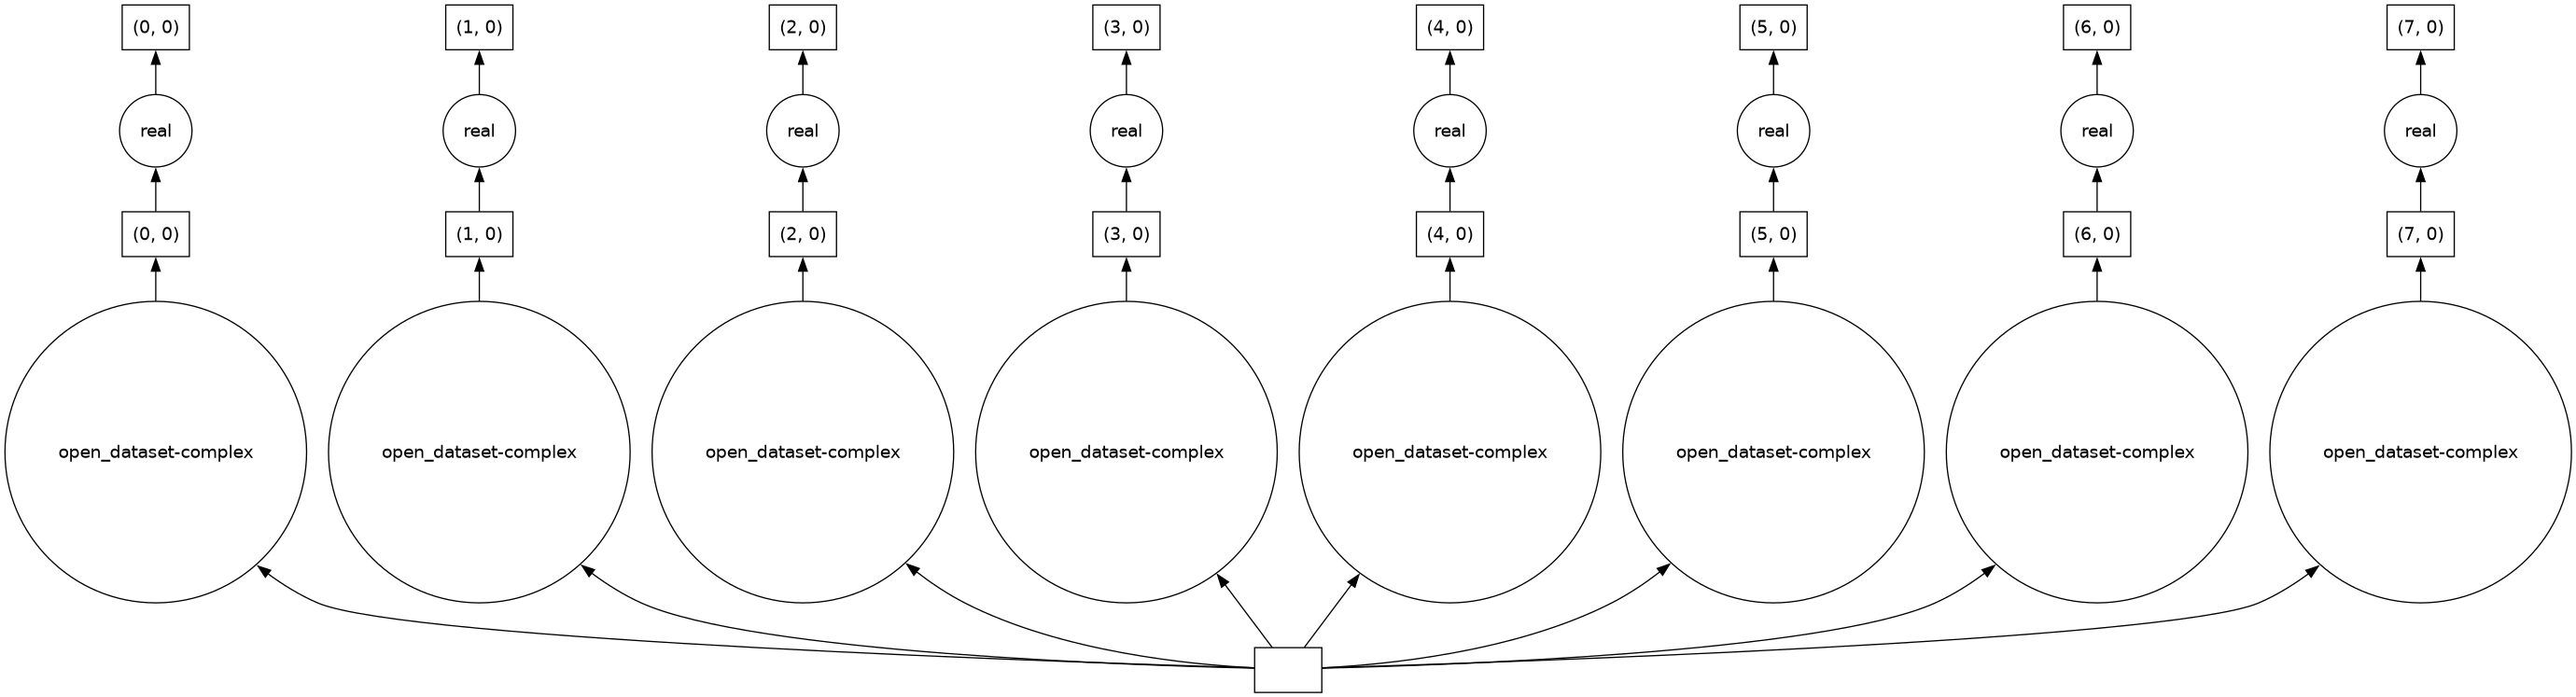

In [4]:
dask.visualize(real_1)

#### Write a function that takes numpy arrays as input, then vectorize it per block

In [5]:
# A function which takes an array
def get_real_array(complex):
    return complex.real

In [6]:
meta_arr = np.array((), dtype=np.float32)

real_2 = da.apply_gufunc(
    get_real_array,
    "()->()",
    stmat["complex"].data,
    meta=meta_arr,
)

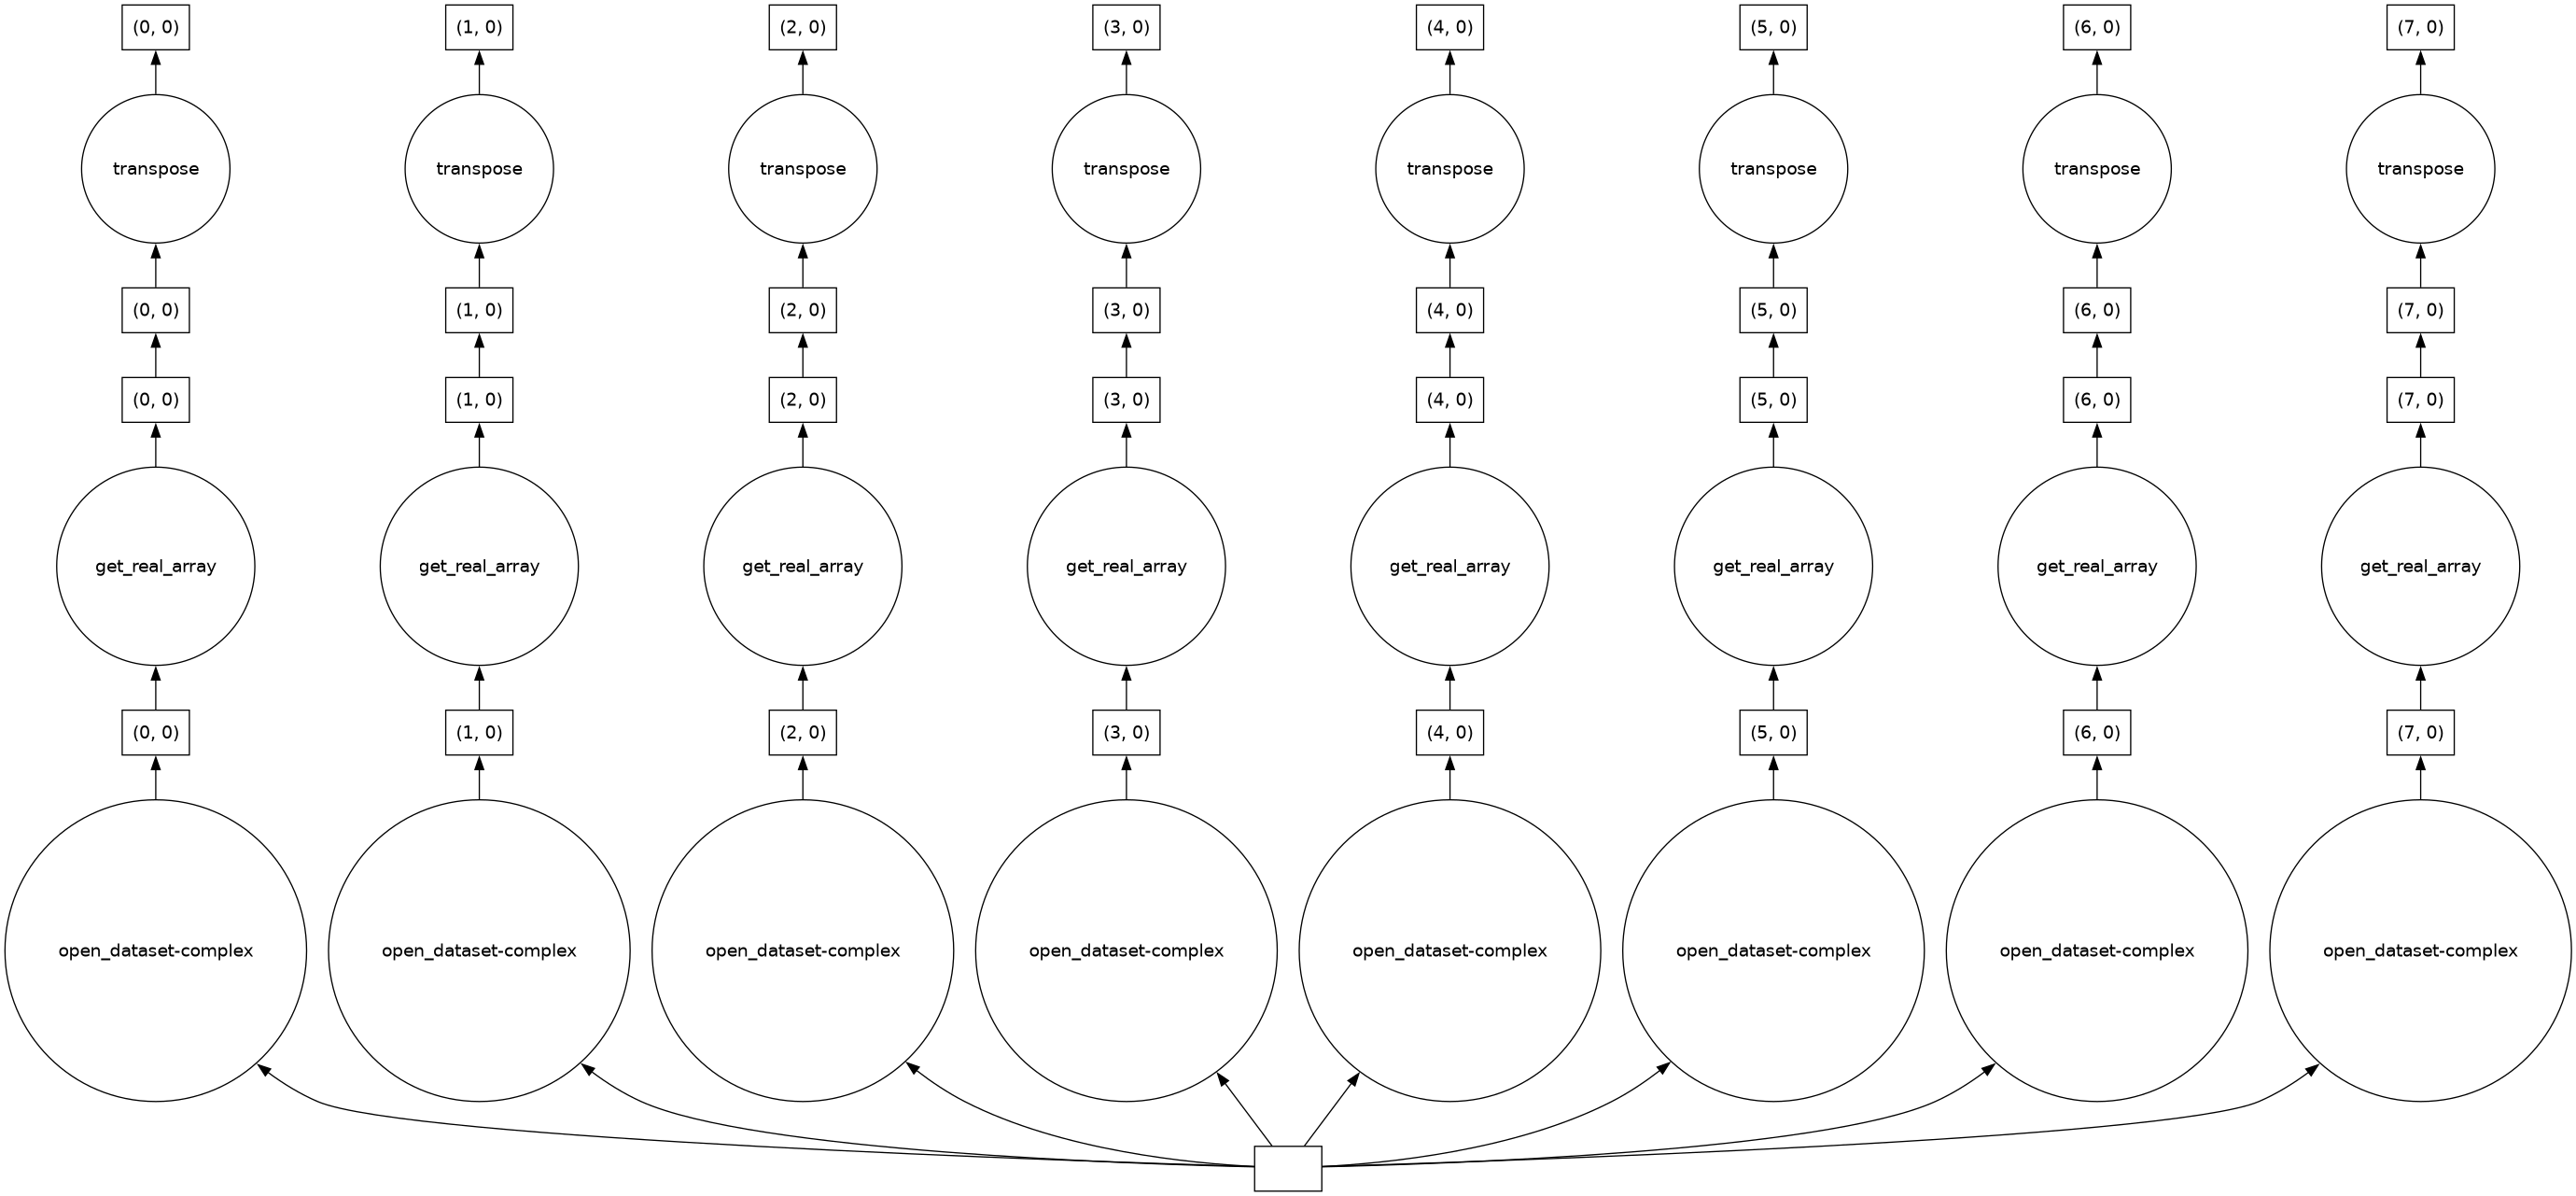

In [7]:
dask.visualize(real_2)

### Write a function that takes a single element as input

In [8]:
# A function which takes a single value
@np.vectorize
def get_real_number(complex):
    if ~np.isnan(complex):
        return complex.real
    else:
        return np.nan

In [9]:
meta_arr = np.array((), dtype=np.float32)

real_3 = da.apply_gufunc(
    get_real_number,
    "()->()",
    stmat["complex"].data,
    meta=meta_arr,
)

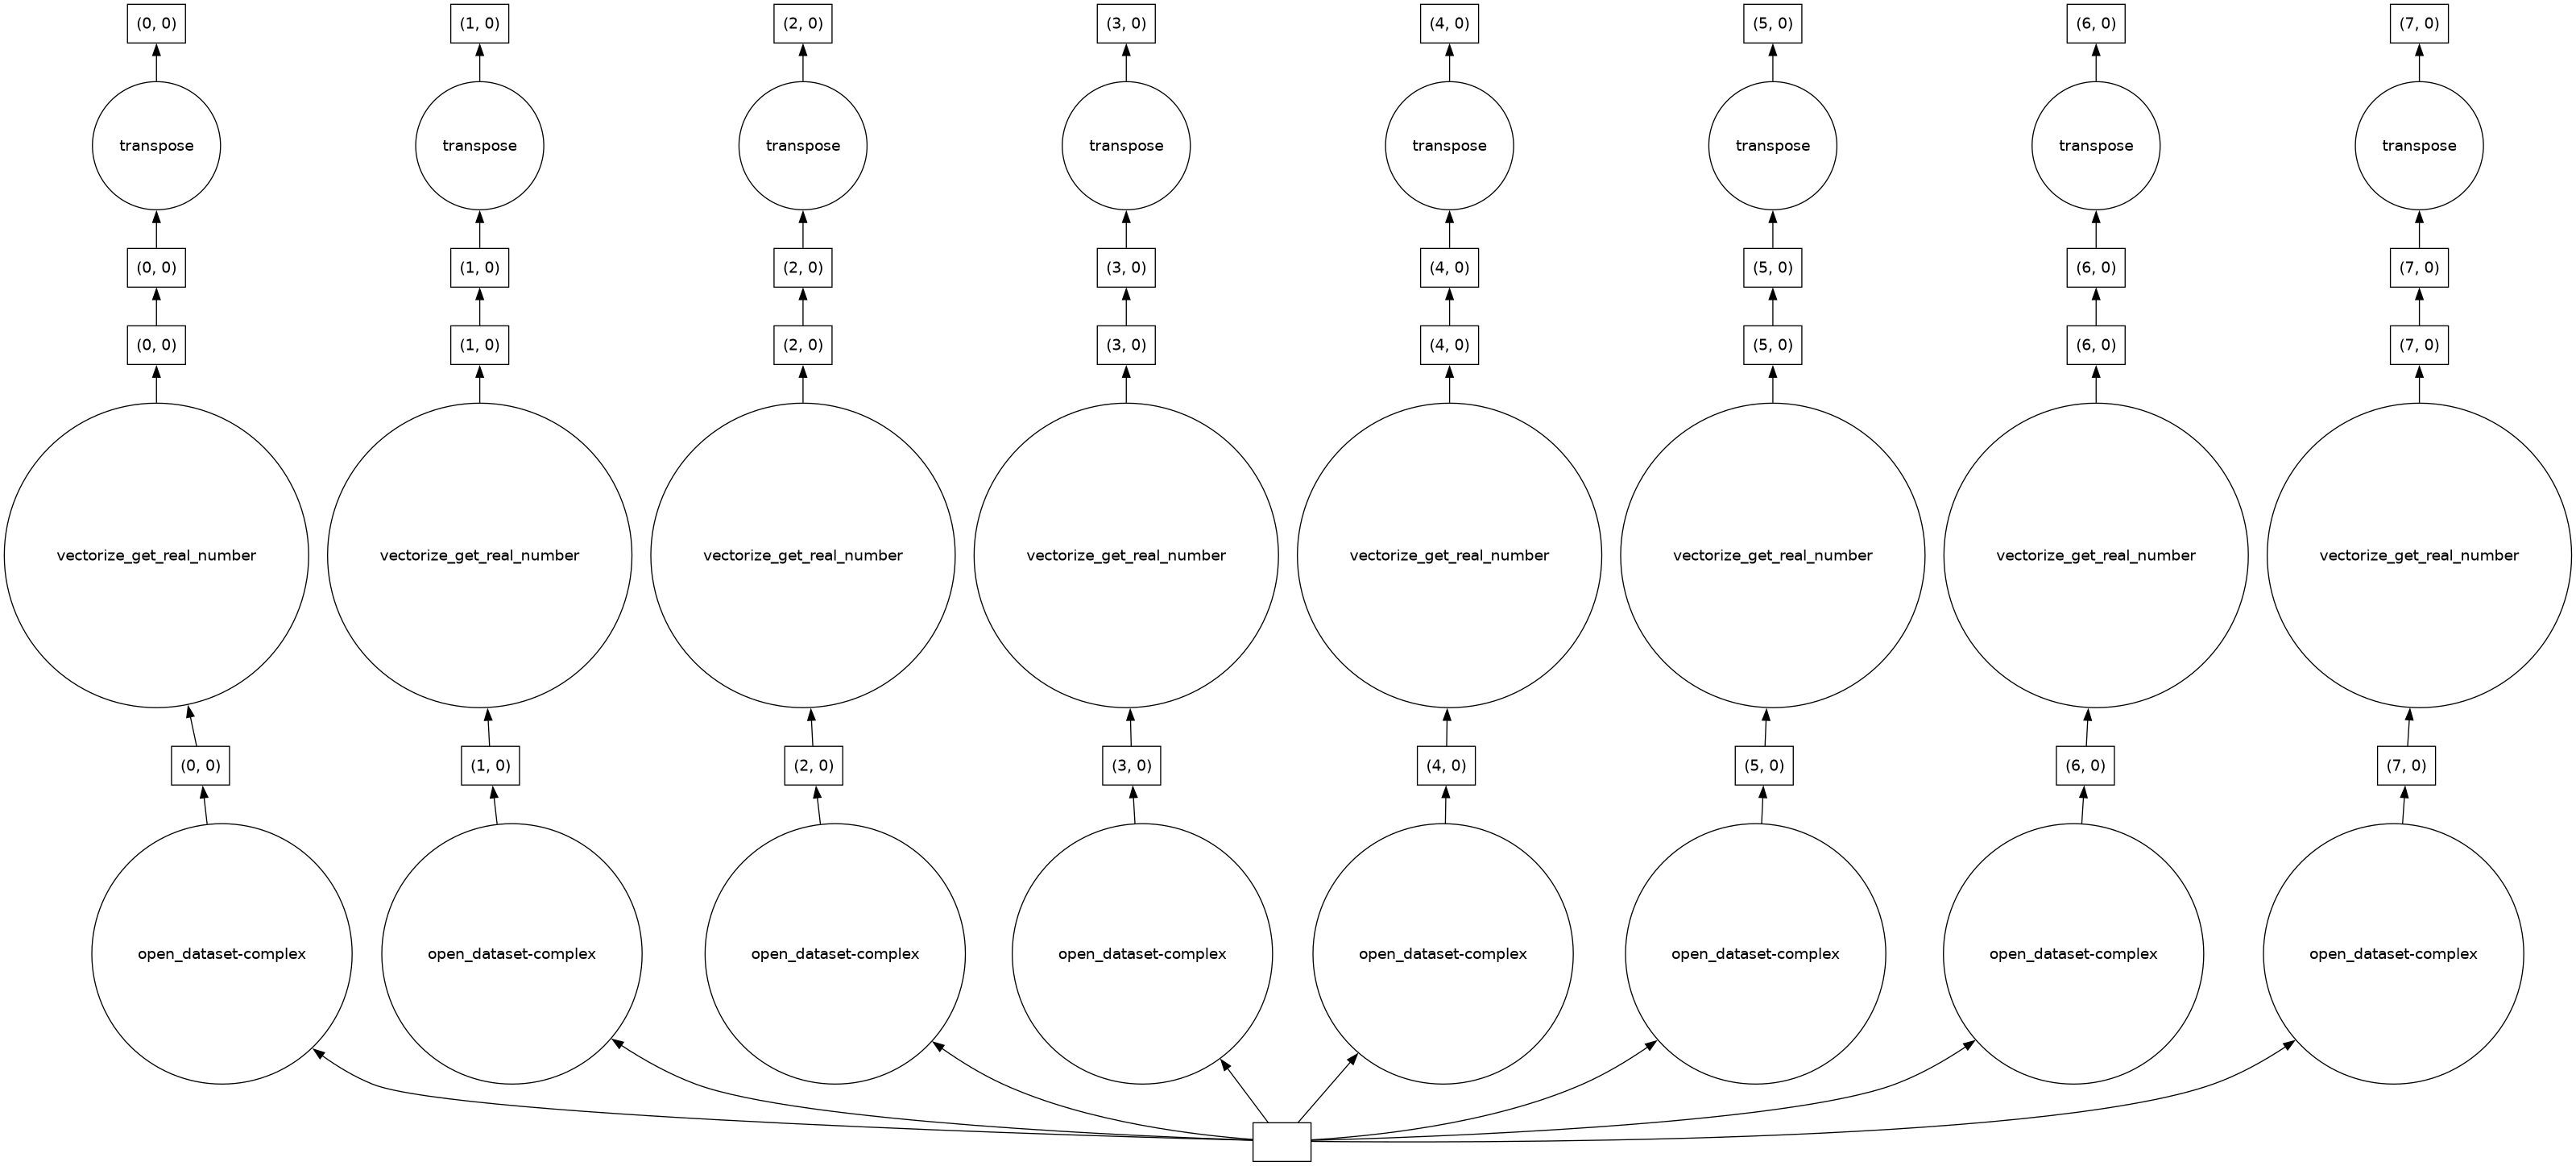

In [10]:
dask.visualize(real_3)

#### After building the task graph

In [11]:
# Re-assign to xarray dataset
stmat["real"] = (("space", "time"), real_3)
stmat

<xarray.Dataset> Size: 18MB
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    real       (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [12]:
# Example of triggering the computation
real_3_comp = real_3.compute()
real_3_comp

array([[   514.93115,   -296.68585,    233.41502, ...,   -375.02396,
          -468.7583 ,    428.09406],
       [ -2632.2842 ,    776.7178 ,   2548.0337 , ...,   3019.0337 ,
         -3931.0288 ,   3837.6934 ],
       [     0.     ,      0.     ,      0.     , ...,      0.     ,
             0.     ,      0.     ],
       ...,
       [ 34810.37   , -15664.879  ,  66410.12   , ...,  45431.094  ,
         20597.82   , -53849.72   ],
       [ -5483.4355 ,  -6193.3354 ,    376.4837 , ...,   2700.0833 ,
          -306.2439 ,   4781.2935 ],
       [ -2147.1392 ,  -3128.516  ,   2229.8782 , ...,  -1608.2722 ,
          2551.9136 ,  -2731.8252 ]], dtype=float32)

### Question

What is the difference between `real_3.compute()` and `stmat['real'].compute()`?

## Example 2: `xr.map_blocks`

In this example, we will parallelize a function that operates on an Xarray dataset, instead of a dask array. This is useful if the function you write requires multiple data variables from an Xarray dataset.

In this example, we will write a dummy function that selects points in a bounding box, which can be potentially expanded to large colume background polygons. It provides a simple example which demonstrates how to use `xr.map_blocks`.

This is adapted a real life example in [stmtools/stm.py](https://github.com/TUDelftGeodesy/stmtools/blob/main/stmtools/stm.py) enrich an STM from Polygons, enriching an STM from large cadastral dataset.

In [13]:
stmat = xr.open_zarr("data/stm.zarr")

In [14]:
from shapely.geometry import box

# A bounding boxes in the region
bbox = [4.85, 52.375, 4.875, 52.425]  # [min_lon, min_lat, max_lon, max_lat]

In [15]:
# For a single bounding box, the following code is efficient

# mask = (
#     (stmat["lon"] >= bbox[0])
#     & (stmat["lon"] <= bbox[2])
#     & (stmat["lat"] >= bbox[1])
#     & (stmat["lat"] <= bbox[3])
# )
# mask = mask.compute()
# stmat_sel = stmat.where(mask, drop=True)

In [16]:
# When writing a block function
# One can check if the background bounding box overlaps with the block
def in_box_block(stmat, bbox):
    # Get the bounding box of the block
    block_bbox = [
        stmat["lon"].min(),
        stmat["lat"].min(),
        stmat["lon"].max(),
        stmat["lat"].max(),
    ]

    # Check if the block bbox overlaps with the bounding box
    if box(*block_bbox).intersects(box(*bbox)):
        mask = (
            (stmat["lon"] >= bbox[0])
            & (stmat["lon"] <= bbox[2])
            & (stmat["lat"] >= bbox[1])
            & (stmat["lat"] <= bbox[3])
        )
    else:
        mask = xr.DataArray(np.zeros(stmat["lon"].shape, dtype=bool), dims=("space"))

    return stmat.where(mask)

In [17]:
stmat_sel = xr.map_blocks(
    in_box_block,
    stmat,
    args=([bbox]),
    template=stmat,
)
stmat_sel

<xarray.Dataset> Size: 14MB
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

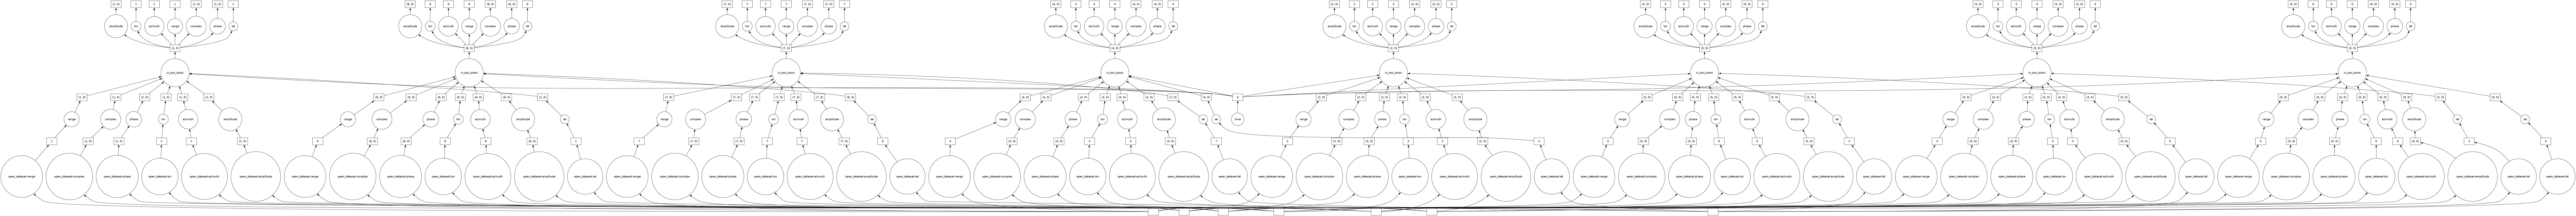

In [18]:
dask.visualize(stmat_sel["amplitude"].data)

In [19]:
stmat_sel = stmat_sel.dropna("space")
stmat_sel

<xarray.Dataset> Size: 953kB
Dimensions:    (space: 5179, time: 10)
Coordinates:
    azimuth    (space) int64 41kB dask.array<chunksize=(5179,), meta=np.ndarray>
    lat        (space) float32 21kB dask.array<chunksize=(5179,), meta=np.ndarray>
    lon        (space) float32 21kB dask.array<chunksize=(5179,), meta=np.ndarray>
    range      (space) int64 41kB dask.array<chunksize=(5179,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 207kB dask.array<chunksize=(5179, 10), meta=np.ndarray>
    complex    (space, time) complex64 414kB dask.array<chunksize=(5179, 10), meta=np.ndarray>
    phase      (space, time) float32 207kB dask.array<chunksize=(5179, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

## Example 3: groupby + map + map_blocks

Sometimes, the function you write only operates with one single point. Directly using `xr.map_blocks` requires you to chunk the STM into each point, which results in many small chunks and huge overhead. If the function you write is not easy to be translated into an array funcyion, a easy trick is to put a `groupby` and `map` function inside the block function.

In this example, we will write a dummy function that calculates the average amplitude of each point. And if the average amplitude is smaller than a threshold, we will set the average amplitude to zero.

This is adapted from a [real life example](https://github.com/MotionbyLearning/example_scripts/blob/main/parallel_compute_example_yuqing/full_batch_group.ipynb), algorithm proposed by Y.Wang.

In [20]:
stmat = xr.open_zarr("data/stm.zarr")

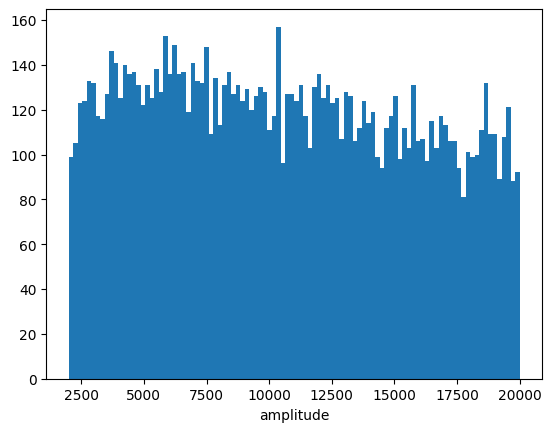

In [22]:
h = stmat["amplitude"].mean(dim="time").plot.hist(bins=100, range=(2000, 20000))

In [23]:
# Point function
# In real life, this function will be more complex
def avg_amp_pnt(stmat_pnt, threshold):
    stmat_pnt["average_amplitude"] = stmat_pnt["amplitude"].mean(dim="time")

    if stmat_pnt["average_amplitude"] < threshold:
        stmat_pnt["average_amplitude"] = 0

    return stmat_pnt

In [24]:
# A block function which calls the point function by groupby
def avg_amp_block(stmat, threshold):
    groups = stmat.groupby("space")
    stmat_out = groups.map(
        avg_amp_pnt,
        threshold=threshold,
    )

    return stmat_out

In [25]:
# Since a new variable is added
# We create a template with the new data variable
stmat_template = stmat.copy()
stmat_template["average_amplitude"] = xr.DataArray(
    np.zeros(stmat.sizes["space"]), dims=("space")
)
stmat_template

<xarray.Dataset> Size: 15MB
Dimensions:            (space: 78582, time: 10)
Coordinates:
    azimuth            (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat                (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon                (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range              (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time               (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude          (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex            (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase              (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    average_amplitude  (space) float64 629kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    multi-look:  coarsen-mean

In [26]:
stmat2 = xr.map_blocks(
    avg_amp_block, stmat, kwargs={"threshold": 1e4}, template=stmat_template
)
stmat2

<xarray.Dataset> Size: 15MB
Dimensions:            (space: 78582, time: 10)
Coordinates:
    azimuth            (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat                (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon                (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range              (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time               (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude          (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    average_amplitude  (space) float64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    complex            (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase              (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [27]:
# Trigger the computation
avg_amp = stmat2["average_amplitude"].compute()

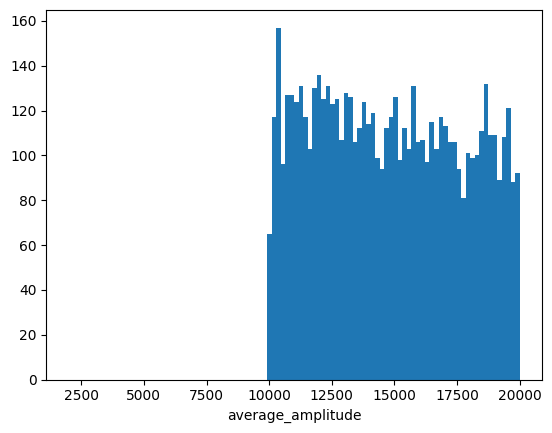

In [29]:
h = avg_amp.plot.hist(bins=100, range=(2000, 20000))